In [3]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from scipy.stats.distributions import norm
from scipy.optimize import fmin, minimize
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VARMAX
import statsmodels.api as sm
# from pydataset import data as pydata
from statsmodels.tsa.stattools import arma_order_select_ic as order_select
import pandas as pd
from scipy import stats
from statsmodels.tsa.api import VARMAX

# Load daily drug sales data

In [9]:
# Load dataset
dfd = pd.read_csv('../Data/salesdaily.csv')
dfd['datum']= pd.to_datetime(dfd['datum'])
dfd["day_number"] = pd.DatetimeIndex(dfd['datum']).day
dfd['Month'] = pd.DatetimeIndex(dfd['datum']).month
dfd['Year'] = pd.DatetimeIndex(dfd['datum']).year
drug_list = dfd.columns[1:9]
dfd.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name,day_number
0,2014-01-02,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday,2
1,2014-01-03,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday,3
2,2014-01-04,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday,4
3,2014-01-05,4.0,3.00,7.0,41.10,8.0,0.0,3.0,0.0,2014,1,276,Sunday,5
4,2014-01-06,5.0,1.00,4.5,21.70,16.0,2.0,6.0,2.0,2014,1,276,Monday,6


In [10]:
# creating training, validation, and test datasets
train, test = train_test_split(dfd, test_size=.1, shuffle=False)

In [11]:
#Check for empty strings 
empty = np.array([(dfd[col].astype(str).unique() == '').any() for col in dfd.columns.tolist()])
print("Any empty strings: " + str((empty == True).any()))

#Check for any missing data
print('\nAny missing data (by column):')
display(dfd.isnull().any())

Any empty strings: False

Any missing data (by column):


datum           False
M01AB           False
M01AE           False
N02BA           False
N02BE           False
N05B            False
N05C            False
R03             False
R06             False
Year            False
Month           False
Hour            False
Weekday Name    False
day_number      False
dtype: bool

# Look at the drug sale data for each drug

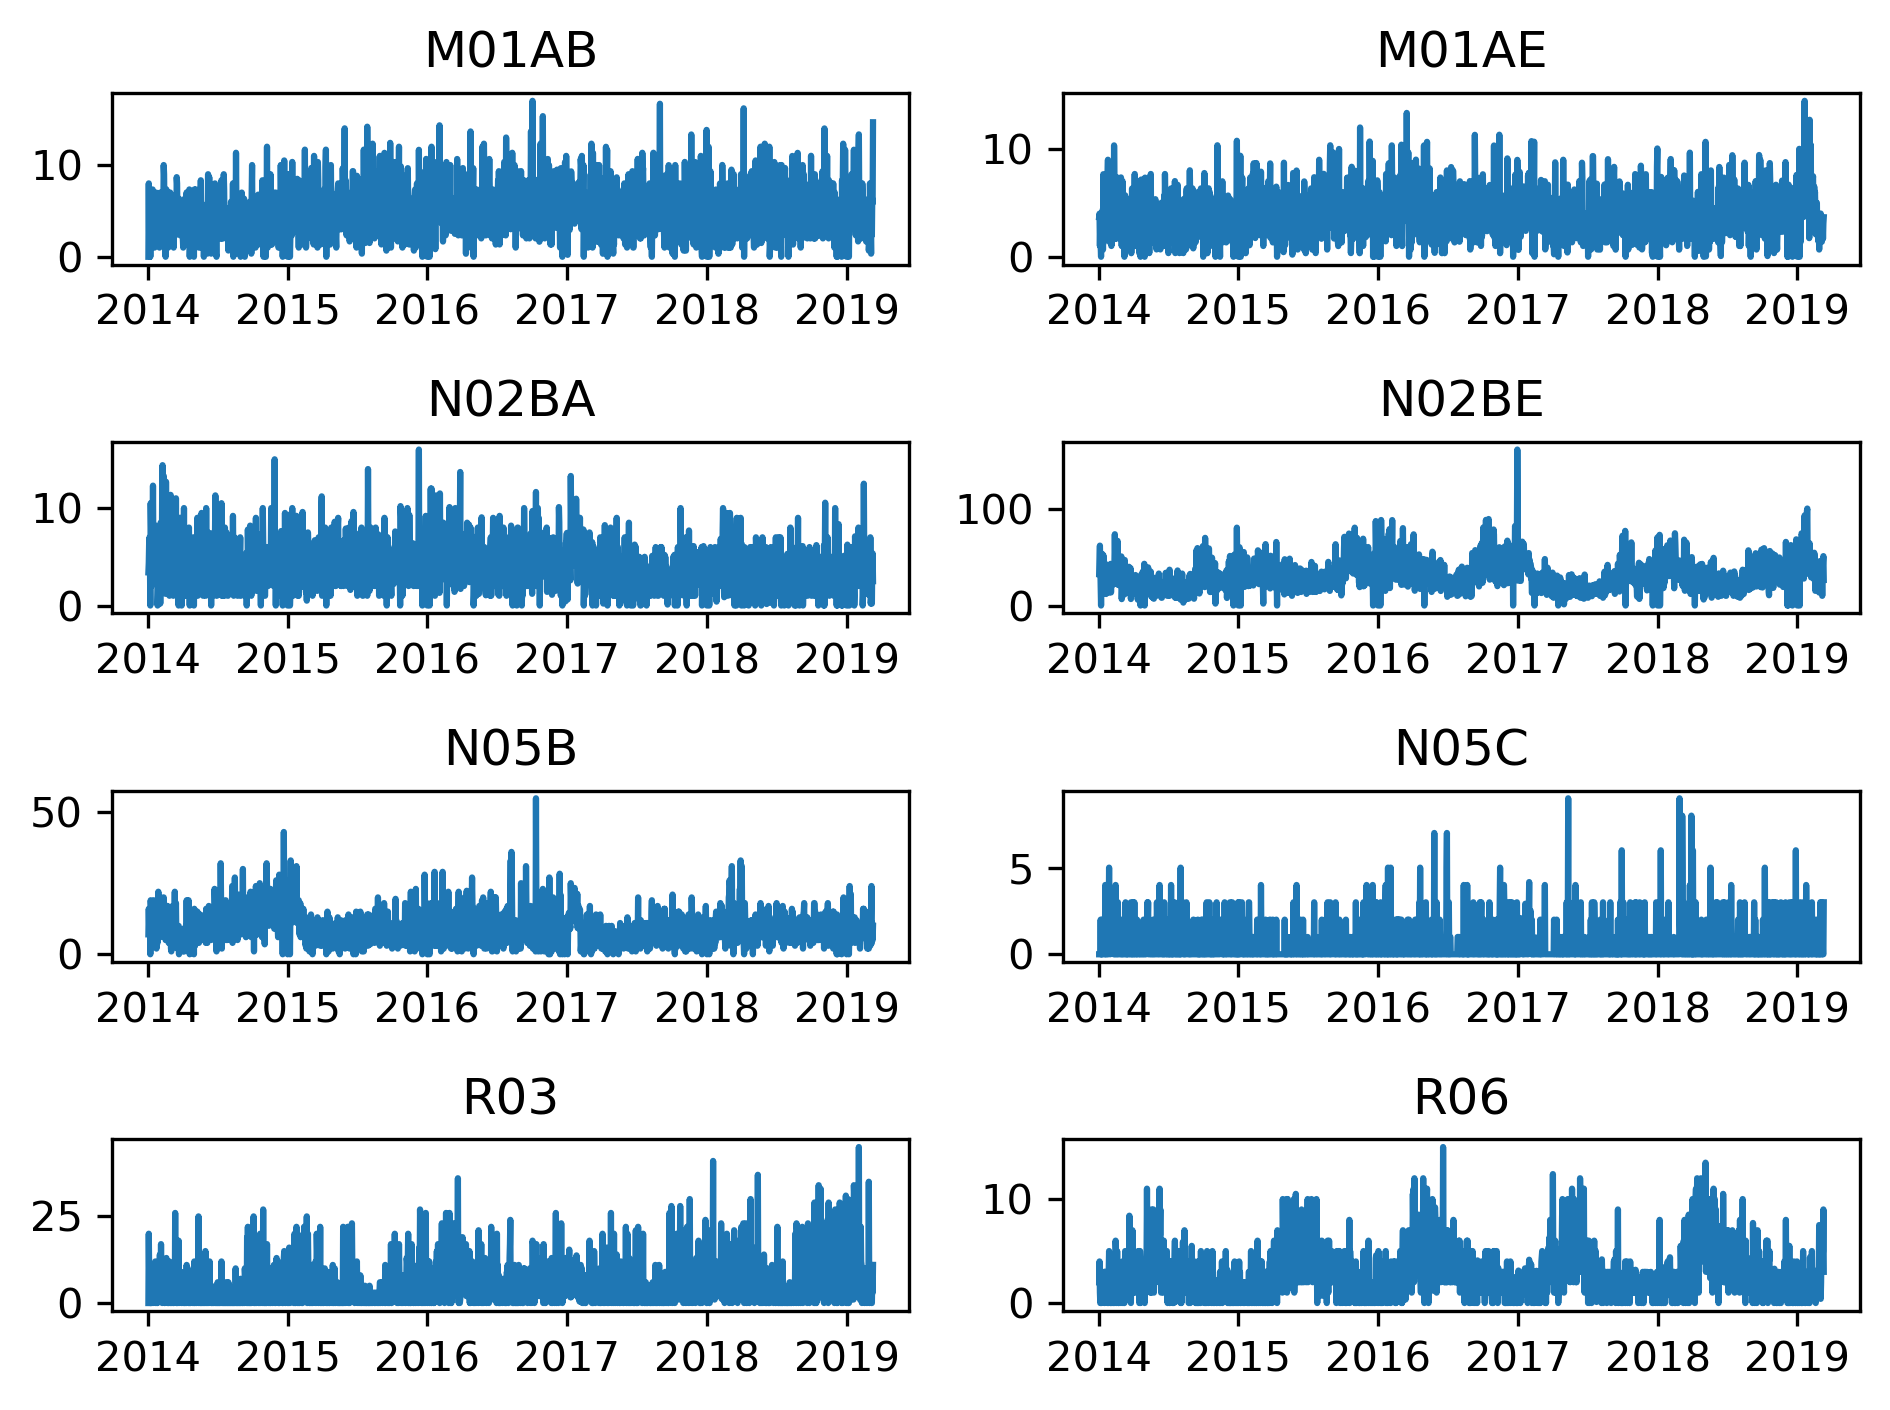

In [29]:
# Plot drug sales over time for each drug
plt.figure(dpi=300)
for i,drug in enumerate(drug_list):
    plt.subplot(4,2,i+1)
    plt.plot(dfd['datum'][:num_train],dfd[drug][:num_train])
    plt.title(drug)
plt.tight_layout()
plt.savefig('../Figures/Supplementary_figure_4.png')
plt.show()

# View drug sales by day of the month

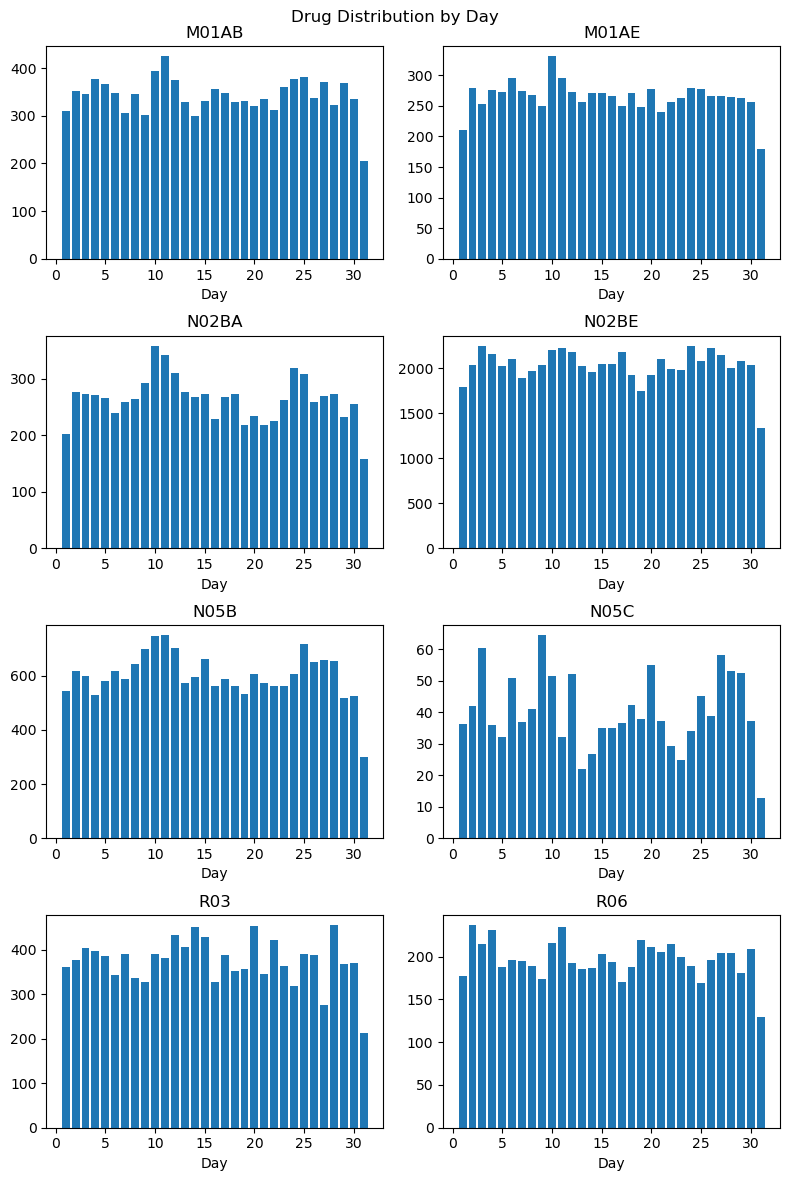

In [13]:
# Group drug sales by week
drug_list = dfd.columns.tolist()[1:9]
gb_year = dfd.groupby(by=['day_number']).sum(numeric_only=True)

# Set plot variables
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(8, 12)

# Create plot
for i, drug in enumerate(drug_list):
    ax[int(np.floor(i/2))][i%2].bar(gb_year.index, gb_year[drug])
    ax[int(np.floor(i/2))][i%2].set_title(drug)
    ax[int(np.floor(i/2))][i%2].set_xlabel('Day')

# Show plot
fig.tight_layout()
fig.suptitle('Drug Distribution by Day')
fig.subplots_adjust(top=0.95)
plt.show()

# Decompose training data

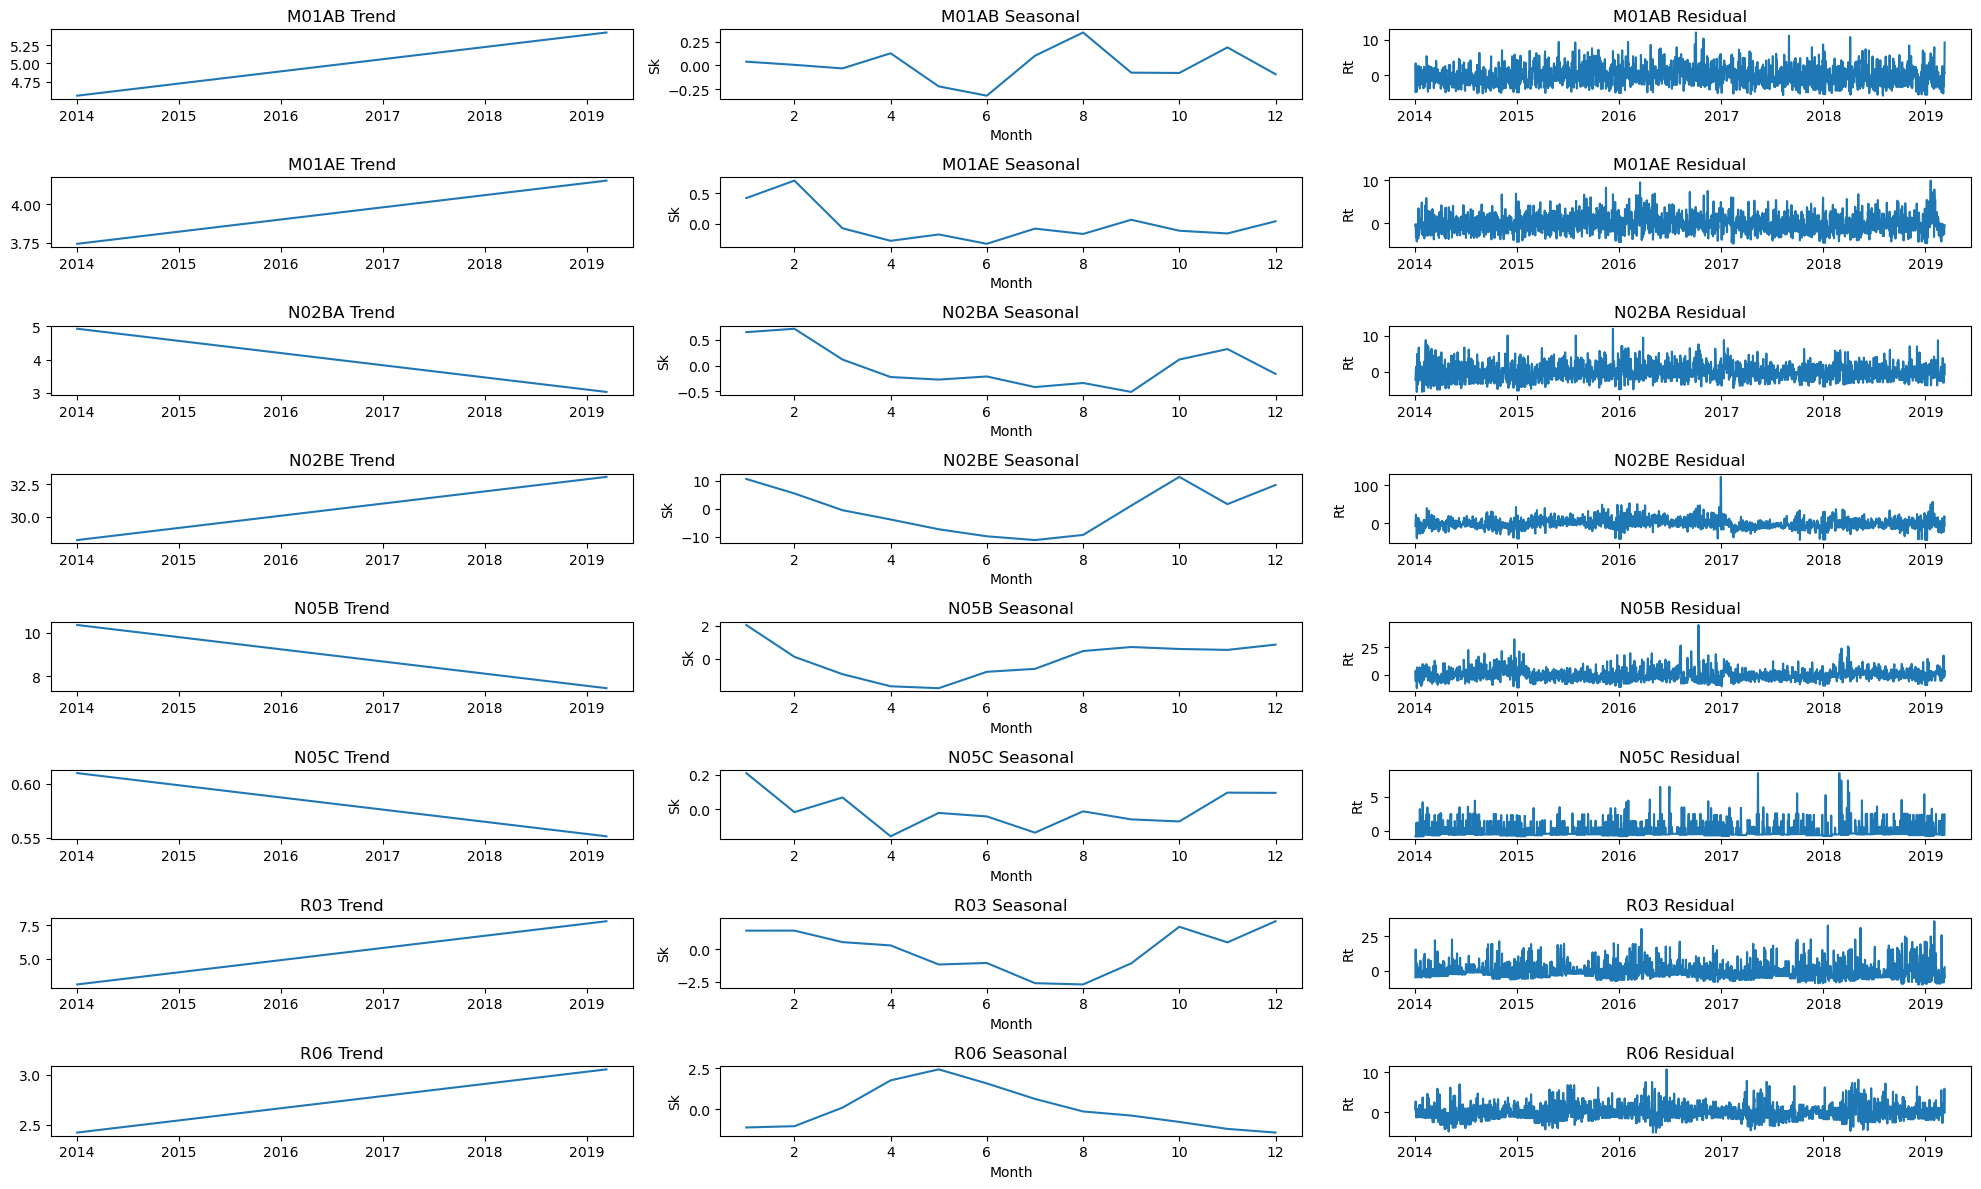

In [14]:
# Set initial variables
fig = plt.figure(figsize=(20,12))
i=1
residuals = {}
trends = {}
seasonal = {}

for col in drug_list:
    #Get drug's time series
    ts = train.set_index('datum')[col]
  
    #Fit polynomial to data
    tlen = 365
    coefficients = np.polyfit(np.arange(len(ts)), list(ts),1)
    poly = np.poly1d(coefficients)
    trends[col] = poly
    dates = ts.index.values
    
    # Get trend
    Tt = poly(np.arange(len(ts)))
    plt.subplot(8,3,i)
    plt.plot(dates, Tt)
    plt.title(f'{col} Trend')

    #Detrend the series
    yt = ts - Tt

    #Find Sk
    Sk = yt.groupby(yt.index.month).mean()
    seasonal[col] = Sk

    #Plot sk
    i += 1
    plt.subplot(8,3,i)
    Sk.plot()
    plt.xlabel('Month')
    plt.ylabel('Sk')
    plt.title(f'{col} Seasonal')

    #Compute residuals
    new = yt.reset_index()
    new['Rt'] = new.apply(lambda row: row[col] - Sk[row['datum'].month], axis=1)
    Rt = new.set_index('datum')['Rt']
    residuals[col] = Rt

    #Plot
    i += 1
    plt.subplot(8,3,i)
    plt.plot(Rt)
    plt.ylabel('Rt')
    plt.title(f'{col} Residual')
    i += 1
plt.tight_layout()
plt.show()

# Look at the distribution of the residuals

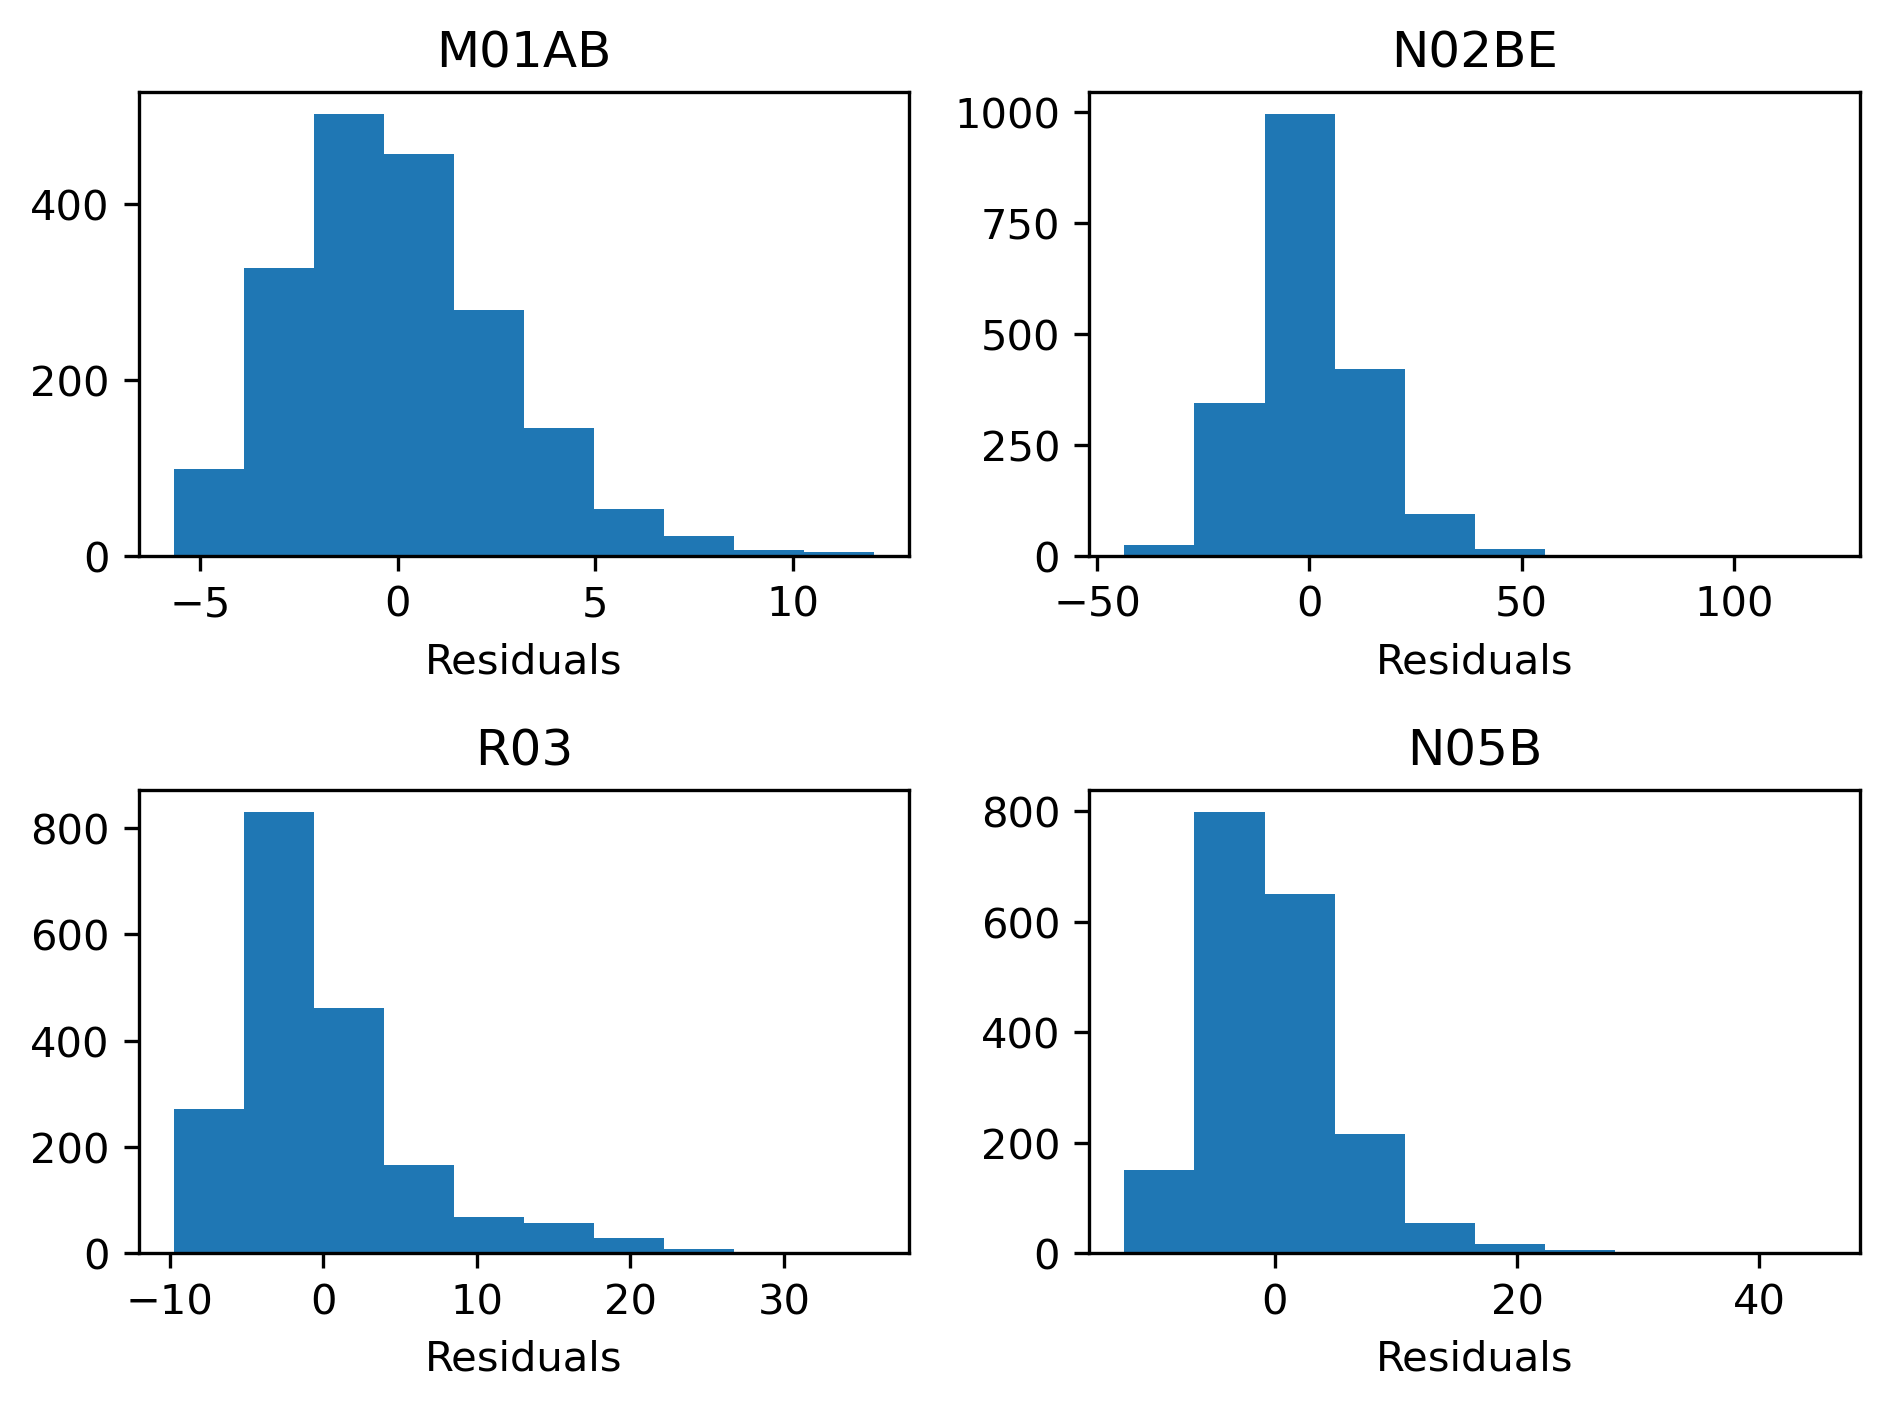

In [19]:
#Get the weekly residuals
plt.figure(dpi=300)
for i,col in enumerate(['M01AB', 'N02BE', 'R03', 'N05B']):
    plt.subplot(2,2,i+1)
    plt.hist(residuals[col])
    plt.title(col)
    plt.xlabel('Residuals')
    
plt.tight_layout()
plt.savefig('../Figures/Figure_2.png')
plt.show()

In [21]:
def model_identification(ts,p_max=4,q_max=4, ours=False):
    """
    Identify parameters to minimize AIC of ARMA(p,q) model

    Parameters:
        file (str): data file
        p (int): maximum order of autoregressive model
        q (int): maximum order of moving average model

    Returns:
        phis (ndarray (p,)): coefficients for AR(p)
        thetas (ndarray (q,)): coefficients for MA(q)
        mu (float): mean of error
        std (float): std of error
    """
    
    # Load time series
    time_series = ts
    n = len(time_series)
    best_aic = np.inf

    # Perform the grid search
    for p in range(1, p_max+1):
        for q in range(1, q_max+1):
            # Create ARIMA model
            model = ARIMA(time_series,order=(p,0,q), trend='c', freq='D').fit(method='innovations_mle')

            # Compute curr aicc
            curr_aic = model.aic

            if curr_aic < best_aic:
                # Update the best model and AIC
                best_model, best_aic = model, curr_aic
                best_p, best_q = p, q
    
    return best_p, best_q 

In [22]:
def arma_forecast(ts, best_p, best_q, n=30):
    """
    Forecast future observations of data.

    Parameters:
        file (str): data file
        phis (ndarray (p,)): coefficients of AR(p)
        thetas (ndarray (q,)): coefficients of MA(q)
        mu (float): mean of ARMA model
        std (float): standard deviation of ARMA model
        n (int): number of forecast observations
    """
    # Load time series
    data = ts

    # Get prediction
    best_model = ARIMA(ts,order=(best_p,0,best_q),trend='c', freq='D').fit(method='innovations_mle')
    prediction = best_model.predict(start=0, end=len(ts)+n)
    forecast = best_model.get_forecast(n)
    conf_int = forecast.conf_int(alpha=0.05)

    # Plot
    dates = pd.date_range(data.index.values[-1], periods=n)
    plt.figure(figsize=(12,10))
    plt.plot(data, label='Old Data')
    plt.plot(prediction, label='forecast')
    plt.plot(conf_int['lower Rt'], 'g', label='95% Confidence Interval')
    plt.plot(conf_int['upper Rt'], 'g')
    plt.xlabel('Day')
    plt.ylabel('Residuals')
    plt.title('ARMA')
    plt.legend()
    plt.show()
    return dates, prediction, conf_int

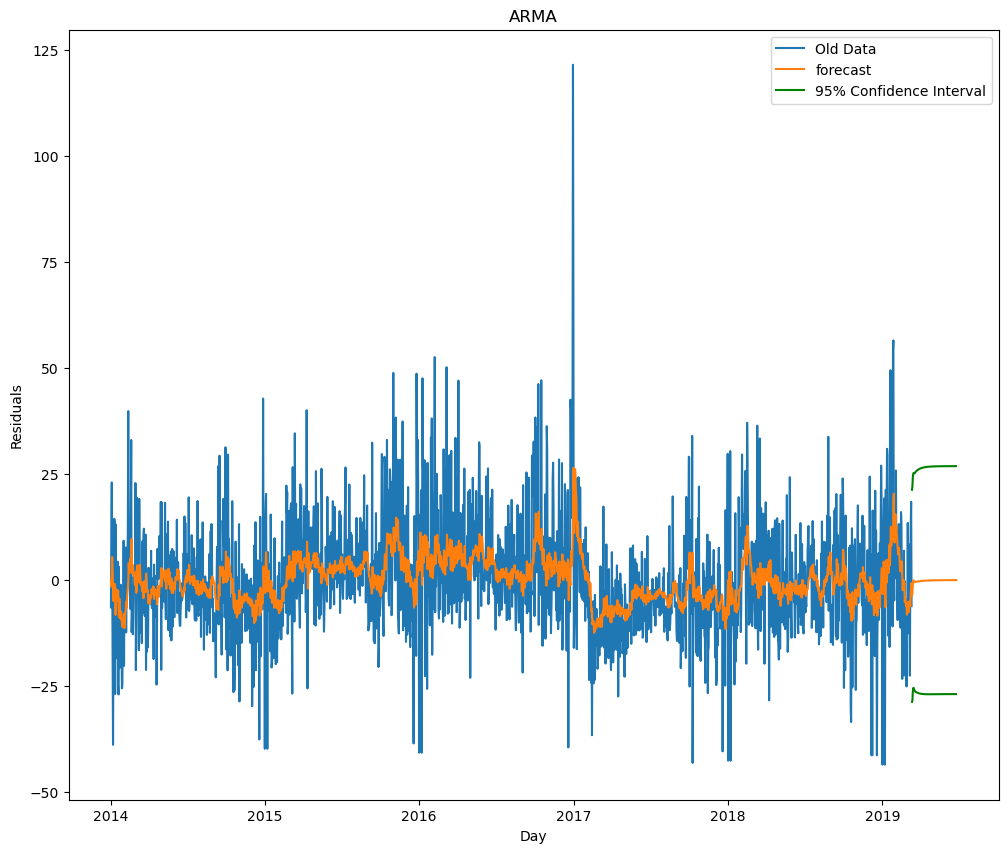

In [54]:
import warnings
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency D will be used.")

# Get ARMA prediction for specific drug
drug = 'N02BE'
n = 105
best_p, best_q = model_identification(residuals[drug], p_max=4, q_max=4, ours=False)
dates, prediction, conf_int = arma_forecast(residuals[drug], best_p,best_q, n=n)


# Show prediction with trend and seasonal added in

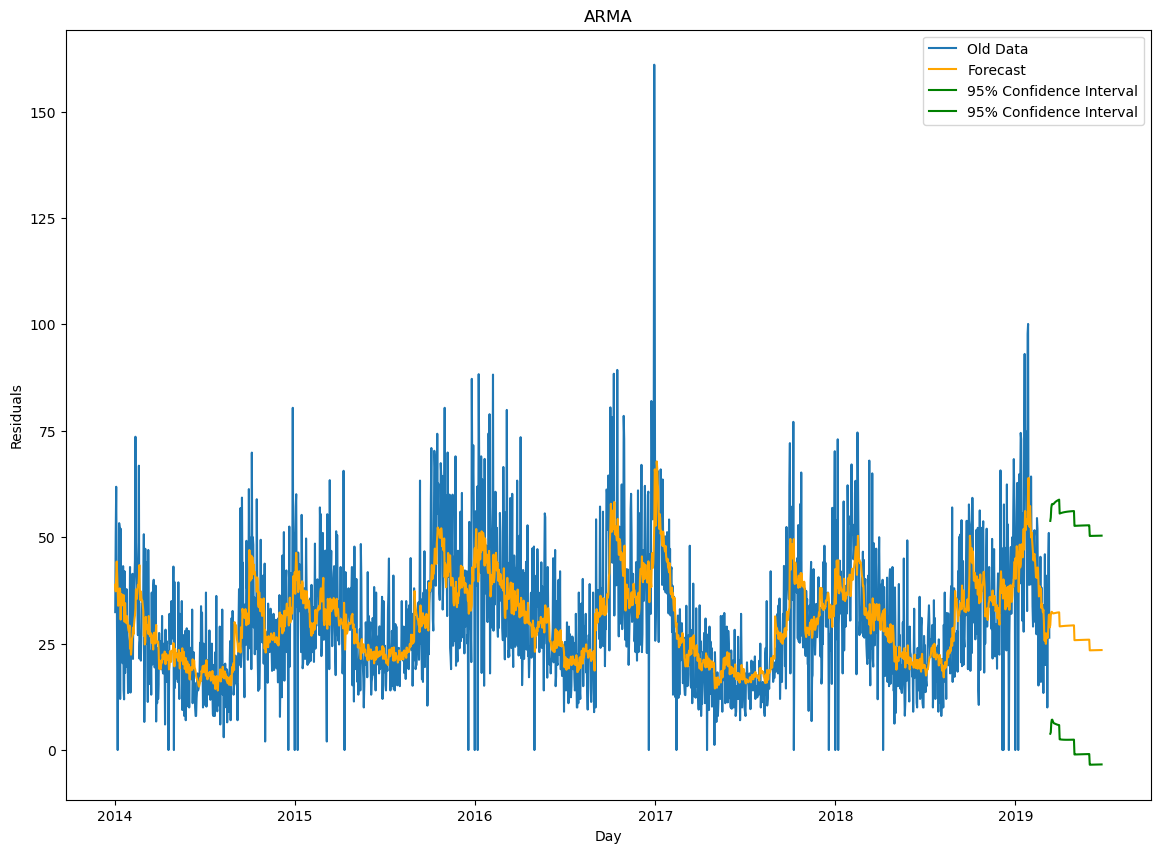

In [55]:
# Set initial variables
t_vals = np.arange(0,len(train) + n + 1)
current_trend = trends[drug](t_vals)
dates = pd.date_range(list(dfd['datum'])[0], periods=len(train) + n + 1)
current_seasonal = seasonal[drug][dates.month]
num_train = len(train)

# Plot
plt.figure(figsize=(14,10))
plt.plot(dfd['datum'][:len(train)], dfd[drug][:len(train)], label='Old Data')
plt.plot(dates, current_trend + list(current_seasonal) + prediction, c='orange', label='Forecast')
plt.plot(dates[num_train+1:], current_trend[num_train+1:] + list(current_seasonal)[num_train+1:] + list(conf_int['lower Rt']), c='g', 
         label='95% Confidence Interval')
plt.plot(dates[num_train+1:], current_trend[num_train+1:] + list(current_seasonal)[num_train+1:] + list(conf_int['upper Rt']), c='g', 
         label='95% Confidence Interval')
plt.xlabel('Day')
plt.ylabel('Residuals')
plt.title('ARMA')
plt.legend()
plt.show()

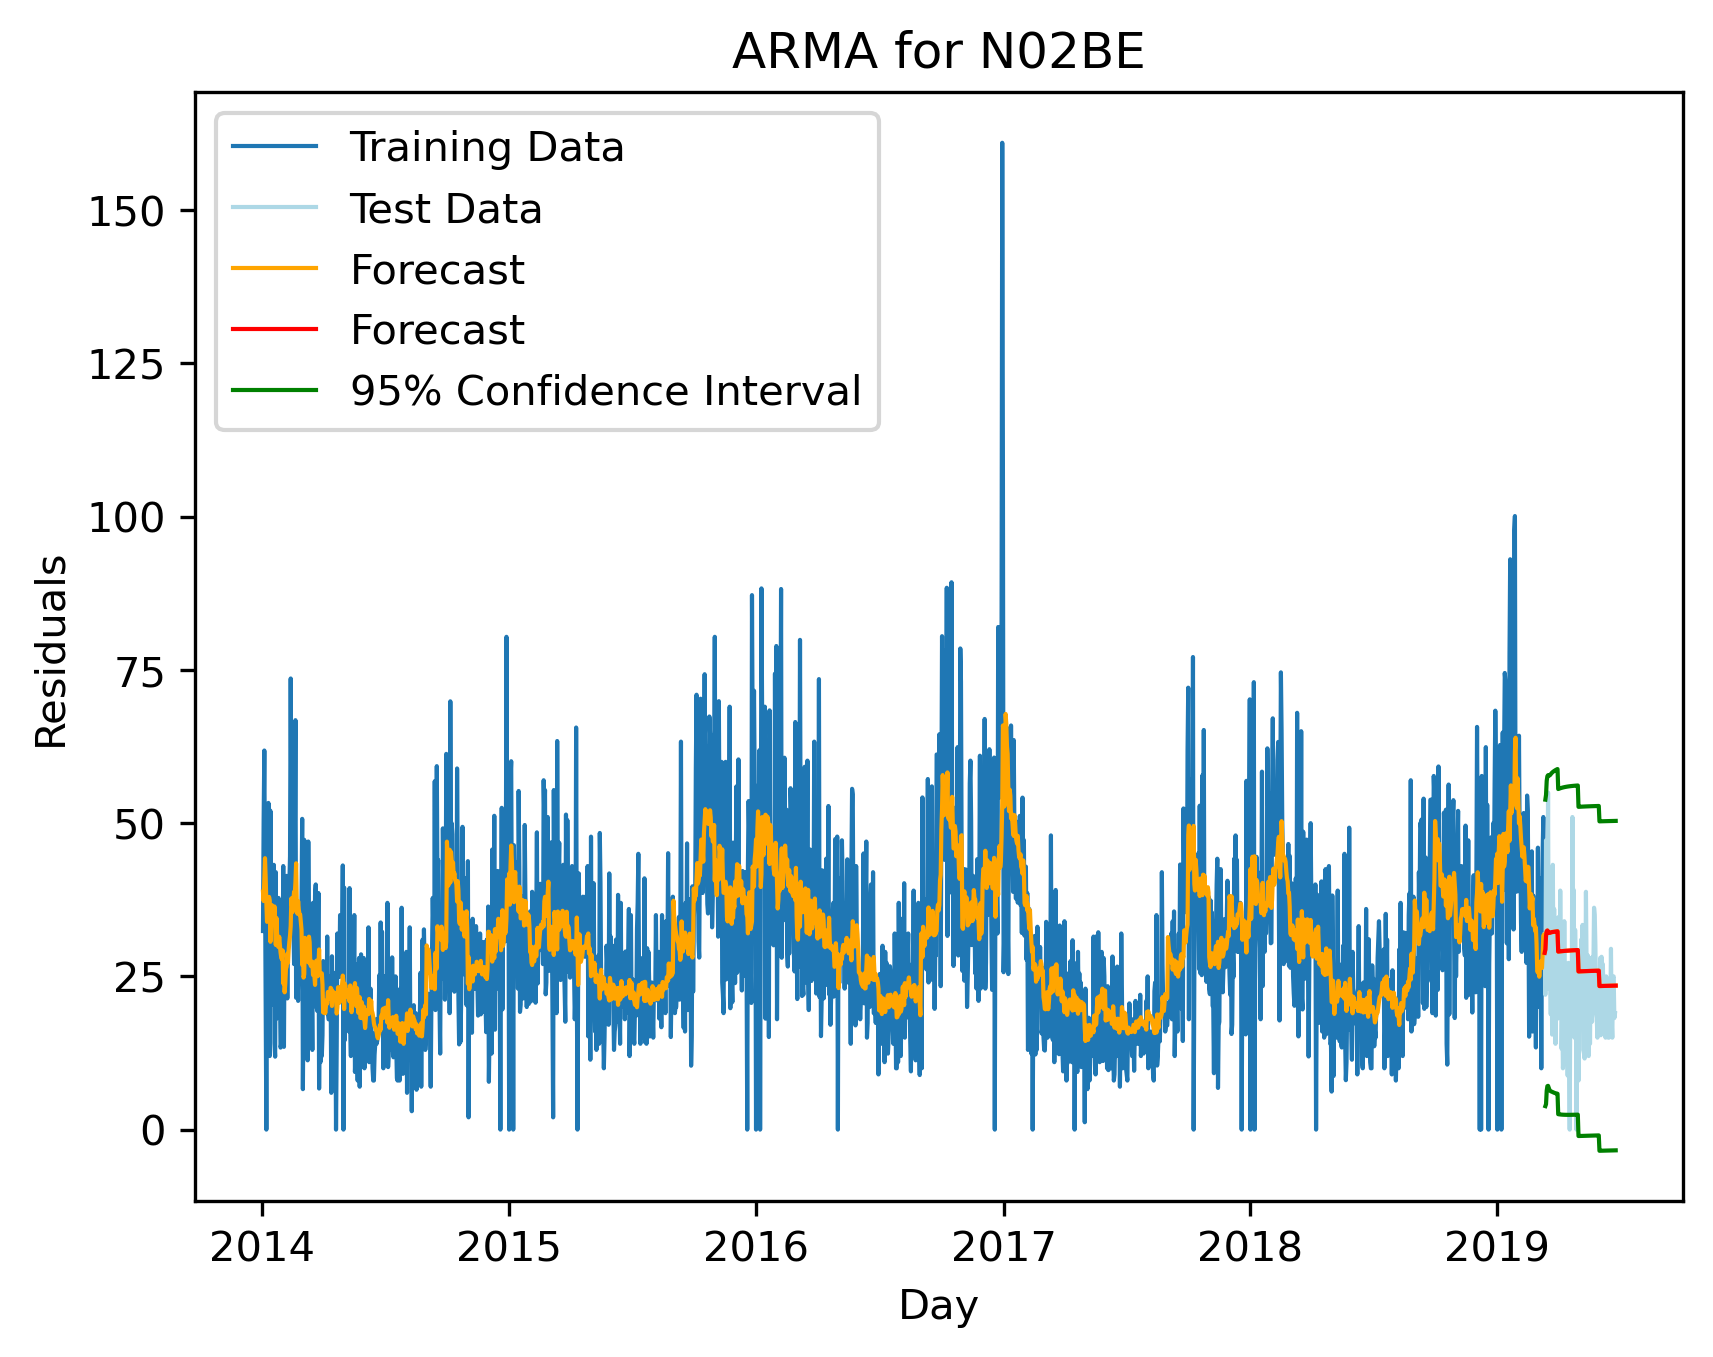

In [56]:
# Set initial variables
t_vals = np.arange(0,len(train) + n + 1)
current_trend = trends[drug](t_vals)
dates = pd.date_range(list(dfd['datum'])[0], periods=len(train) + n + 1)
current_seasonal = seasonal[drug][dates.month]
num_train = len(train)

# Plot
plt.figure(dpi=300)
plt.plot(dfd['datum'][:num_train], dfd[drug][:num_train], label='Training Data', linewidth=1)
plt.plot(dfd['datum'][num_train:num_train+n], dfd[drug][num_train:num_train+n], 
         label='Test Data', color='lightblue', linewidth=1)
plt.plot(dates, current_trend + list(current_seasonal) + prediction, 
         c='orange', label='Forecast', linewidth=1)
plt.plot(dates[num_train:], (current_trend + list(current_seasonal) + prediction)[num_train:], 
         c='red', label='Forecast', linewidth=1)
plt.plot(dates[num_train+1:], current_trend[num_train+1:] + list(current_seasonal)[num_train+1:] + list(conf_int['lower Rt']), c='g', 
         label='95% Confidence Interval', linewidth=1)
plt.plot(dates[num_train+1:], current_trend[num_train+1:] + list(current_seasonal)[num_train+1:] + list(conf_int['upper Rt']), c='g'
         , linewidth=1)
plt.xlabel('Day')
plt.ylabel('Residuals')
plt.title('ARMA for ' + drug)
plt.legend()
plt.savefig('../Figures/N02BE_ARMA.png')
plt.show()

# Try multivariate ARIMA

In [274]:
def sm_varma(df, drug_list):
    """
    Build an VARMAX model with statsmodel and
    predict future n values.

    Parameters:
        start (str): the data at which to begin forecasting
        end (str): the date at which to stop forecasting

    Return:
        aic (float): aic of optimal model
    """
    
    
    # Create DatetimeIndex
    # dates = df[['year', 'quarter']].astype(int).astype(str)
    # dates = dates["year"] + "Q" + dates["quarter"]
    # dates = dates_from_str(dates)
    df = df.set_index('datum')
    
    # Select columns used in prediction
    df = df[drug_list].iloc[:-1,:]
    end = list(test['datum'])[-150]
    
    # Create model
    mod = VARMAX(df, freq='D')
    mod = mod.fit(maxiter=1000, disp=False, ic='aic')
    pred = mod.predict(df.index.values[-1],end)
    
    # # Get confidence intervals
    # forecast_obj = mod.get_forecast(end)
    # all_CI = forecast_obj.conf_int(alpha=0.05)
    
    plt.figure(figsize=(10,10))
    for i,drug in enumerate(drug_list):
    
        # Create realgdp plot
        plt.subplot(4,2,i+1)
        plt.plot(df[drug], label = drug)
        plt.plot(pred.index.values,list(pred[drug]),
                 label='forcast')
        plt.xlabel('year')
        plt.ylabel('drug sales')
        plt.title(drug)
        plt.legend()
    plt.tight_layout()
    plt.show()
        
    return pred

/Users/chloehart/Documents/anaconda3/lib/python3.8/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: ic. After release 0.14, this will raise.
  warnings.warn(


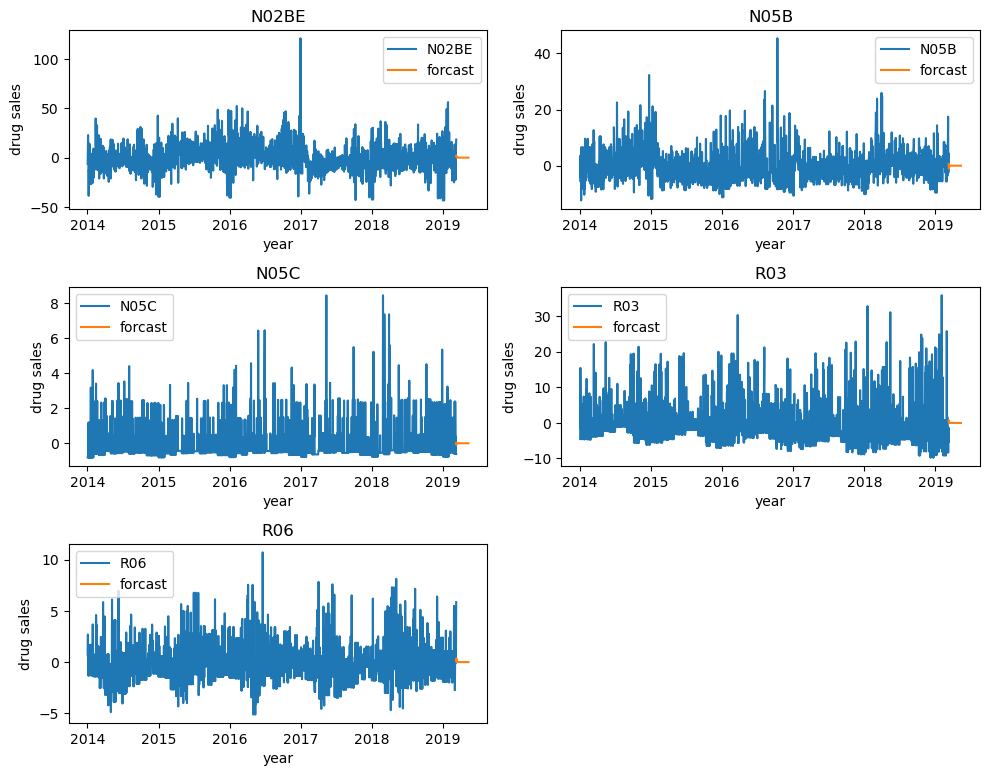

In [275]:
# create residuals data frame
residual_df = train.copy()
for drug in drug_list:
    residual_df[drug] = list(residuals[drug])

pred = sm_varma(residual_df, drug_list[3:])

64 64 64


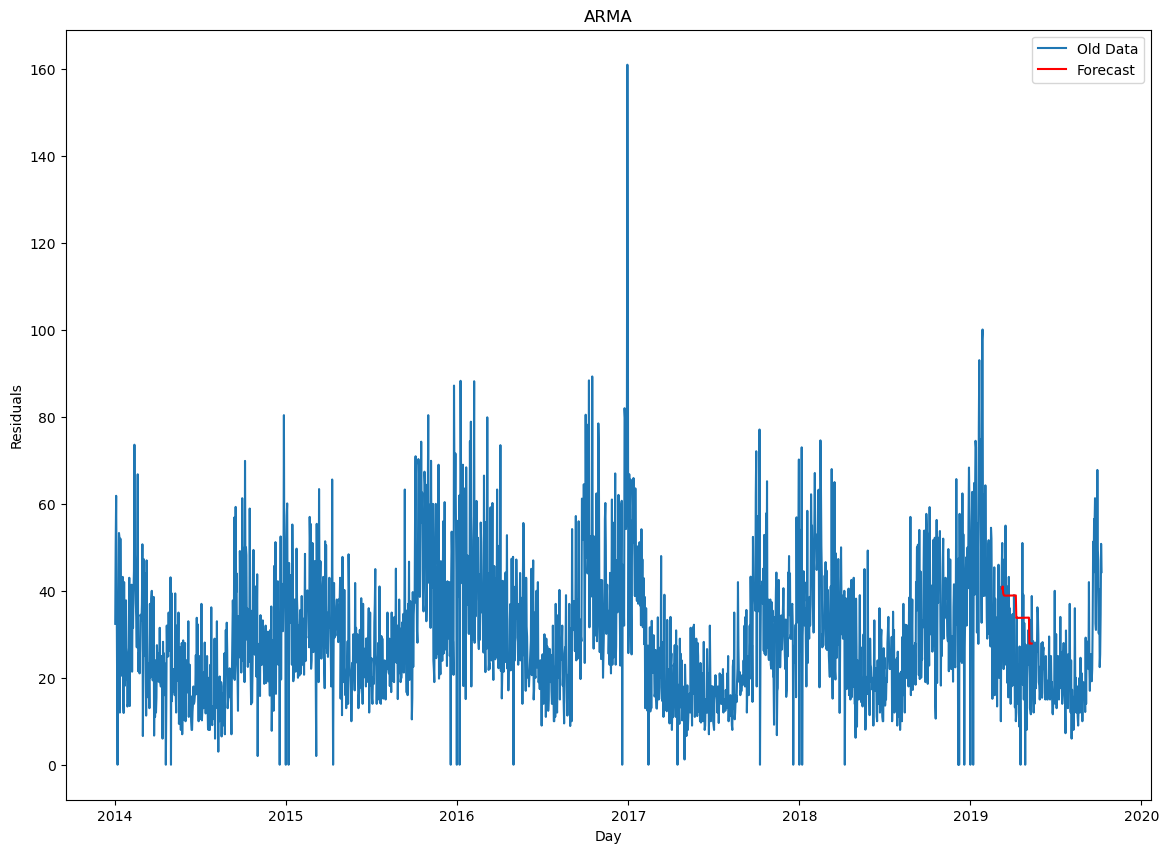

In [276]:
# Set initial variables
drug = 'N02BE'
t_vals = np.arange(0,64)
current_trend = trends[drug](t_vals)
dates = pd.date_range(list(dfd['datum'])[0], periods=64)
current_seasonal = seasonal[drug][dates.month]
num_train = len(train)
print(len(current_trend), len(current_seasonal), len(pred[drug]))

# Plot
plt.figure(figsize=(14,10))
plt.plot(dfd['datum'], dfd[drug], label='Old Data')
plt.plot(current_trend + list(current_seasonal) + pred[drug], c='red', label='Forecast')
plt.xlabel('Day')
plt.ylabel('Residuals')
plt.title('ARMA')
plt.legend()
plt.show()